# **DEMO 3: PHYSICAL THERAPY EXERCISES DATASET**

# **Load Libraries and Dataset**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load test.txt for s1/e1/u1
df = pd.read_csv("sample_data/test.txt", sep=";")

df.head()

,time index,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,mag_x,mag_y,mag_z
0,1,-9.685645,-1.645149,0.505022,-0.020696,0.009202,-0.008566,0.589728,0.453403,-0.075234
1,2,-9.648184,-1.645353,0.513125,-0.008165,-0.001407,-0.003256,0.587024,0.453644,-0.075593
2,3,-9.700570,-1.615223,0.512321,-0.004447,0.011059,-0.008589,0.589691,0.454598,-0.075525
3,4,-9.685627,-1.630183,0.497591,-0.026110,0.009183,-0.008554,0.589240,0.452864,-0.074705
4,5,-9.655697,-1.630194,0.460742,-0.008109,0.001231,-0.005950,0.589647,0.452882,-0.076429


# **Data Preprocessing**
# Noise Reduction




In [ ]:
# Import library
from scipy.signal import butter, filtfilt

# Define low-pass filter
# cutoff= 5, Sampling Frequency = 25
def butter_lowpass_filter(data, cutoff=5, fs=25, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# Apply filter to all sensor columns
sensor_cols = ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z', 'mag_x', 'mag_y', 'mag_z']
filtered_df = df.copy()

for col in sensor_cols:
    filtered_df[col] = butter_lowpass_filter(df[col])

print(filtered_df.head())

   time index     acc_x     acc_y     acc_z     gyr_x     gyr_y     gyr_z  \
0           1 -9.685630 -1.645162  0.505015 -0.020692  0.009205 -0.008569   
1           2 -9.679506 -1.633288  0.513231 -0.011530  0.006494 -0.007618   
2           3 -9.677860 -1.626683  0.509099 -0.010186  0.005257 -0.006592   
3           4 -9.678784 -1.627153  0.492218 -0.015284  0.006056 -0.005829   
4           5 -9.677205 -1.630729  0.473147 -0.018546  0.008489 -0.006508   

      mag_x     mag_y     mag_z  
0  0.589727  0.453404 -0.075233  
1  0.588778  0.453781 -0.075352  
2  0.588633  0.453774 -0.075523  
3  0.589187  0.453503 -0.075594  
4  0.589699  0.453392 -0.075327  


# Z Sore Normalization

In [ ]:
# Import library
from sklearn.preprocessing import StandardScaler

# Z-score normalization
scaler = StandardScaler()
filtered_df[sensor_cols] = scaler.fit_transform(filtered_df[sensor_cols])

print(filtered_df.describe())

        time index         acc_x         acc_y        acc_z         gyr_x  \
count  5949.000000  5.949000e+03  5.949000e+03  5949.000000  5.949000e+03   
mean   2975.000000  4.028439e-14 -4.261584e-15     0.000000 -1.289941e-16   
std    1717.472707  1.000084e+00  1.000084e+00     1.000084  1.000084e+00   
min       1.000000 -5.122965e+00 -5.554262e+00    -2.176729 -5.789093e+00   
25%    1488.000000 -6.905368e-01 -7.179618e-01    -0.965699 -5.272486e-01   
50%    2975.000000 -1.754222e-02 -4.633928e-02     0.243574  9.239209e-03   
75%    4462.000000  6.985397e-01  6.780559e-01     0.833754  5.466793e-01   
max    5949.000000  4.469789e+00  4.674743e+00     2.002110  5.149997e+00   

              gyr_y         gyr_z         mag_x         mag_y        mag_z  
count  5.949000e+03  5.949000e+03  5.949000e+03  5.949000e+03  5949.000000  
mean  -2.866537e-17  2.149902e-17 -2.996486e-14 -2.274119e-14     0.000000  
std    1.000084e+00  1.000084e+00  1.000084e+00  1.000084e+00     1.000084 

# Data Segmentation

In [ ]:
# Data Segmentation
# step size = 12 (50% overlap), 1 sec window (sampling rate 25Hz)
def segment_signal_with_overlap(df, window_size=25, overlap=0.5):
    step = int(window_size * (1 - overlap))
    segments = []

    for start in range(0, len(df) - window_size + 1, step):
        end = start + window_size
        segment = df.iloc[start:end]
        segments.append(segment)

    return segments

# Use 50% overlap
segments = segment_signal_with_overlap(filtered_df, window_size=25, overlap=0.5)
print(f"Total overlapping windows: {len(segments)}")


Total overlapping windows: 494


# **Extract Time-Domain Features**

In [ ]:
from scipy.stats import skew, kurtosis, iqr
from scipy.signal import find_peaks
import numpy as np

def extract_time_features(segment):
    features = {}
    axes = ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z', 'mag_x', 'mag_y', 'mag_z']

    for axis in axes:
        signal = segment[axis].values

        # Basic statistics
        features[f'{axis}_mean'] = np.mean(signal)
        features[f'{axis}_std'] = np.std(signal)
        features[f'{axis}_var'] = np.var(signal)
        features[f'{axis}_min'] = np.min(signal)
        features[f'{axis}_max'] = np.max(signal)
        features[f'{axis}_range'] = np.max(signal) - np.min(signal)
        features[f'{axis}_median'] = np.median(signal)
        features[f'{axis}_iqr'] = iqr(signal)
        features[f'{axis}_rms'] = np.sqrt(np.mean(signal**2))
        features[f'{axis}_skew'] = skew(signal)
        features[f'{axis}_kurtosis'] = kurtosis(signal)

        # Zero-Crossing Rate
        zero_crossings = np.where(np.diff(np.signbit(signal)))[0]
        features[f'{axis}_zcr'] = len(zero_crossings)

        # Autocorrelation (lag-1)
        if len(signal) > 1:
            autocorr = np.corrcoef(signal[:-1], signal[1:])[0, 1]
        else:
            autocorr = 0
        features[f'{axis}_autocorr'] = autocorr

        # Peak Count and Max Peak Amplitude
        peaks, _ = find_peaks(signal)
        features[f'{axis}_peak_count'] = len(peaks)
        features[f'{axis}_peak_amplitude'] = np.max(signal[peaks]) if len(peaks) > 0 else 0

        # Energy
        features[f'{axis}_energy'] = np.sum(signal ** 2)

    # Signal Magnitude Area (SMA) for accelerometer
    acc_x = segment['acc_x'].values
    acc_y = segment['acc_y'].values
    acc_z = segment['acc_z'].values
    sma = np.sum(np.abs(acc_x) + np.abs(acc_y) + np.abs(acc_z)) / len(acc_x)
    features['acc_sma'] = sma

    return features

time_features_list = [extract_time_features(segment) for segment in segments]
time_features_df = pd.DataFrame(time_features_list)

In [ ]:
time_features_df.head()

,acc_x_mean,acc_x_std,acc_x_var,acc_x_min,acc_x_max,acc_x_range,acc_x_median,acc_x_iqr,acc_x_rms,acc_x_skew,...,mag_z_iqr,mag_z_rms,mag_z_skew,mag_z_kurtosis,mag_z_zcr,mag_z_autocorr,mag_z_peak_count,mag_z_peak_amplitude,mag_z_energy,acc_sma
0,-0.872759,0.328954,0.108211,-1.599133,-0.194581,1.404552,-0.872645,0.354334,0.932694,-0.190892,...,0.031829,0.060557,0.079805,-0.916008,0,0.623766,4,-0.005183,0.091680,1.659534
1,-0.596141,0.368783,0.136001,-1.147965,0.330491,1.478457,-0.689314,0.289135,0.700988,1.155456,...,0.030714,0.056356,-0.425826,-0.859475,0,0.697839,4,-0.016505,0.079400,1.417827
2,-0.368770,0.532950,0.284035,-1.595636,0.493982,2.089618,-0.417211,0.720829,0.648094,-0.212282,...,0.031214,0.045898,0.243549,-0.285747,2,0.760244,4,0.014890,0.052665,1.324560
3,-0.480361,0.732983,0.537264,-1.614123,1.086460,2.700582,-0.424969,1.258464,0.876362,0.125701,...,0.055720,0.036022,-0.295219,-0.995225,5,0.823030,4,0.034550,0.032439,1.425064
4,-0.627860,0.717406,0.514671,-1.614123,1.086460,2.700582,-0.622569,0.991939,0.953351,0.524222,...,0.163869,0.122589,0.551188,-1.296373,3,0.970614,4,0.246448,0.375700,1.412691


# **Extract Frequency Domain Features**


In [ ]:
from scipy.fftpack import fft
from scipy.signal import welch
import numpy as np

#frequency based features
def extract_frequency_features(segment, sampling_rate=25):
    features = {}
    axes = ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z', 'mag_x', 'mag_y', 'mag_z']

    for axis in axes:
        signal = segment[axis].values
        N = len(signal)
        freqs = np.fft.fftfreq(N, d=1/sampling_rate)[:N//2]
        fft_vals = np.abs(fft(signal))[:N//2]
        fft_vals /= np.sum(fft_vals) + 1e-12  # Normalize

        # Spectral Energy
        features[f'{axis}_fft_energy'] = np.sum(fft_vals ** 2)

        # Spectral Entropy
        features[f'{axis}_fft_entropy'] = -np.sum(fft_vals * np.log2(fft_vals + 1e-12))

        # Peak Frequency (maximum FFT magnitude)
        features[f'{axis}_fft_peak'] = np.max(fft_vals)

        # Dominant Frequency (frequency with highest FFT value)
        dom_freq_idx = np.argmax(fft_vals)
        features[f'{axis}_dominant_freq'] = freqs[dom_freq_idx]

        # Spectral Centroid
        spectral_centroid = np.sum(freqs * fft_vals)
        features[f'{axis}_spectral_centroid'] = spectral_centroid

        # Frequency Variance
        features[f'{axis}_freq_variance'] = np.sum(((freqs - spectral_centroid) ** 2) * fft_vals)

        # Spectral Flatness
        geometric_mean = np.exp(np.mean(np.log(fft_vals + 1e-12)))
        arithmetic_mean = np.mean(fft_vals)
        features[f'{axis}_spectral_flatness'] = geometric_mean / (arithmetic_mean + 1e-12)

        # Bandwidth from PSD
        psd_freqs, psd = welch(signal, fs=sampling_rate, nperseg=min(256, N))
        total_power = np.sum(psd)
        cumulative_power = np.cumsum(psd)
        low = psd_freqs[np.searchsorted(cumulative_power, 0.25 * total_power)]
        high = psd_freqs[np.searchsorted(cumulative_power, 0.75 * total_power)]
        features[f'{axis}_bandwidth'] = high - low

        # PSD Features
        features[f'{axis}_psd_mean'] = np.mean(psd)
        features[f'{axis}_psd_peak'] = np.max(psd)

        # FFT Coefficients (first 3)
        for i in range(3):
            features[f'{axis}_fft_coef_{i}'] = fft_vals[i] if i < len(fft_vals) else 0

    return features

# Apply to segments
freq_features_list = [extract_frequency_features(segment) for segment in segments]
freq_features_df = pd.DataFrame(freq_features_list)

# Combine Time + Frequency



In [ ]:
# Combine time and frequency features
combined_df = pd.concat([time_features_df, freq_features_df], axis=1)
# Fill NaNs with 0
combined_df.fillna(0, inplace=True)

# **Feature Selection using Random Forest**

In [ ]:
# Prepare data
import numpy as np

# Create labels for y
# 10 repetitions per execution type
# 3 types: "correct", "fast", "low-amplitude"

n_per_class = len(combined_df) // 3 # no. of samples for each execution type
y = np.array(["correct"] * n_per_class + ["fast"] * n_per_class + ["low"] * (len(combined_df) - 2 * n_per_class))

In [ ]:
# Train Random Forest and get Feature Importances
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

X = combined_df  # full feature set

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

importances = rf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display top 20 features
print(importance_df.head(20))

                  Feature  Importance
102          mag_x_median    0.066269
36              acc_z_max    0.047288
96             mag_x_mean    0.047147
142  mag_z_peak_amplitude    0.043686
100             mag_x_max    0.042466
110  mag_x_peak_amplitude    0.042206
131             mag_z_min    0.041300
128            mag_z_mean    0.037633
112            mag_y_mean    0.034711
46   acc_z_peak_amplitude    0.032899
132             mag_z_max    0.031463
99              mag_x_min    0.028465
16             acc_y_mean    0.027611
134          mag_z_median    0.025376
32             acc_z_mean    0.024110
35              acc_z_min    0.023960
0              acc_x_mean    0.023221
116             mag_y_max    0.023211
38           acc_z_median    0.019909
118          mag_y_median    0.018462


In [ ]:
# Reduce feature set to top 20 features
top_features = importance_df.head(20)['Feature'].tolist()
X_reduced = X[top_features]

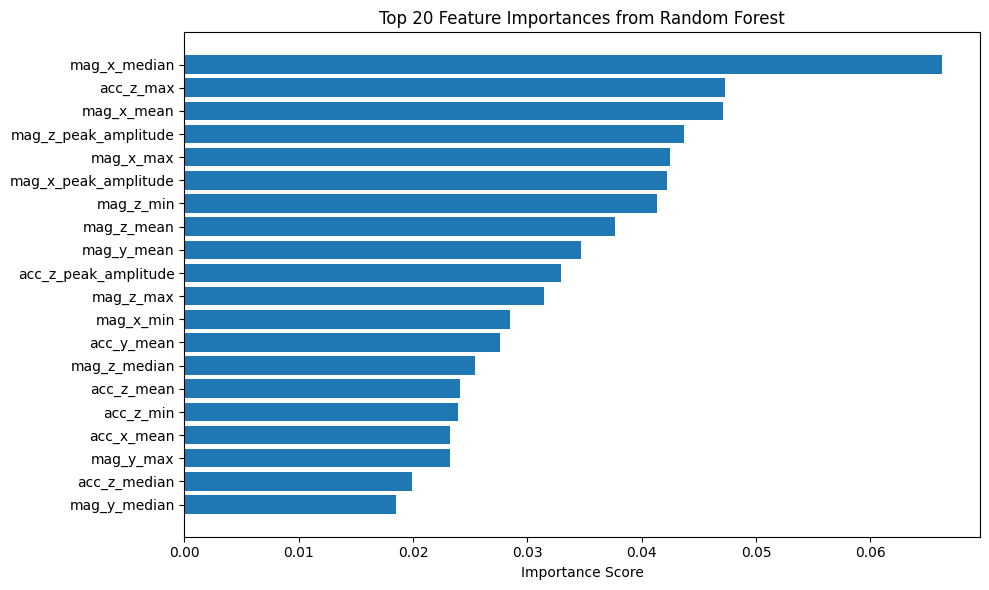

In [ ]:
# Visualize feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(20), importance_df['Importance'].head(20))
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances from Random Forest")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# **Model Development**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Define a dictionary with all models; trained and evaluated below
models = {
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "Decision Tree": DecisionTreeClassifier()
}

print(" Models defined successfully.")

 Models defined successfully.


# **Model Evaluation**

# Leave One Subject Out

In [ ]:
# Load test2.txt for another subject
df_s2 = pd.read_csv("sample_data/test2.txt", sep=";")

# Data Preprocessing
# Low-pass filter
filtered_df_s2 = df_s2.copy()
for col in sensor_cols:
    filtered_df_s2[col] = butter_lowpass_filter(df_s2[col])

# Z-Score Normalization
# Fit on Subject 1's data (training subject)
scaler = StandardScaler()
scaler.fit(filtered_df[sensor_cols])

# Apply to Subject 2 (test subject)
filtered_df_s2[sensor_cols] = scaler.transform(filtered_df_s2[sensor_cols])

# Data Segmentation
segments_s2 = segment_signal_with_overlap(filtered_df_s2, window_size=25, overlap=0.5)

**Feature Extraction**

In [ ]:
# Time Domain Features
time_features_list_s2 = [extract_time_features(segment) for segment in segments_s2]
time_features_df_s2 = pd.DataFrame(time_features_list_s2)

# Frequency Domain Features
freq_features_list_s2 = [extract_frequency_features(segment) for segment in segments_s2]
freq_features_df_s2 = pd.DataFrame(freq_features_list_s2)

# Combined Feature Set
combined_df_s2 = pd.concat([time_features_df_s2, freq_features_df_s2], axis=1)
combined_df_s2.fillna(0, inplace=True)

**Labelling**

In [ ]:
# Trim X_s1 and X_s2 to match class labels
n_s1 = len(combined_df) // 3
y_s1 = ["correct"] * n_s1 + ["fast"] * n_s1 + ["low"] * (len(combined_df) - 2 * n_s1)
X_s1 = combined_df.iloc[:len(y_s1)]  # trim to match y_s1

n_s2 = len(combined_df_s2) // 3
y_s2 = ["correct"] * n_s2 + ["fast"] * n_s2 + ["low"] * (len(combined_df_s2) - 2 * n_s2)
X_s2 = combined_df_s2.iloc[:len(y_s2)]  # trim to match y_s2

# Apply top-20 feature selection
top_20 = importance_df.head(20)['Feature'].tolist()
X_s1_reduced = X_s1[top_20]
X_s2_reduced = X_s2[top_20]


In [ ]:
X_s1_reduced.head()

,mag_x_median,acc_z_max,mag_x_mean,mag_z_peak_amplitude,mag_x_max,mag_x_peak_amplitude,mag_z_min,mag_z_mean,mag_y_mean,acc_z_peak_amplitude,mag_z_max,mag_x_min,acc_y_mean,mag_z_median,acc_z_mean,acc_z_min,acc_x_mean,mag_y_max,acc_z_median,mag_y_median
0,0.804280,0.355487,0.761168,-0.005183,1.052957,1.052957,-0.097448,-0.055524,-0.642061,0.355487,-0.005183,0.264440,0.586410,-0.052431,0.200365,0.045312,-0.872759,-0.489622,0.221269,-0.668843
1,0.742227,0.296998,0.666671,-0.016505,1.123825,1.123825,-0.097448,-0.051791,-0.685480,0.296998,-0.016505,0.120687,0.603734,-0.047080,0.159818,-0.002738,-0.596141,-0.381538,0.156602,-0.692104
2,0.587243,0.304133,0.631606,0.014890,1.123825,1.123825,-0.079588,-0.039469,-0.719211,0.304133,0.014890,0.120687,0.651391,-0.039924,0.131331,-0.048100,-0.368770,-0.381538,0.129784,-0.686451
3,0.842048,0.304133,0.801171,0.034550,1.262345,1.262345,-0.079588,-0.013318,-0.769048,0.304133,0.038633,0.219808,0.586318,-0.008478,0.099321,-0.048100,-0.480361,-0.408739,0.083292,-0.779354
4,0.638042,0.164467,0.700488,0.246448,1.262345,1.262345,-0.026645,0.082721,-0.619923,0.154595,0.246448,0.247223,0.510978,0.038633,0.008312,-0.093117,-0.627860,-0.186745,-0.014647,-0.623102


In [ ]:
X_s2_reduced.head()

,mag_x_median,acc_z_max,mag_x_mean,mag_z_peak_amplitude,mag_x_max,mag_x_peak_amplitude,mag_z_min,mag_z_mean,mag_y_mean,acc_z_peak_amplitude,mag_z_max,mag_x_min,acc_y_mean,mag_z_median,acc_z_mean,acc_z_min,acc_x_mean,mag_y_max,acc_z_median,mag_y_median
0,0.483846,-0.091593,0.483829,-0.004192,0.485208,0.484126,-0.006300,-0.004615,0.592542,-0.221461,-0.001266,0.482809,-3.513811,-0.004571,-0.246764,-0.322612,-9.147140,0.593345,-0.249106,0.592545
1,0.483214,0.256885,0.482458,0.011501,0.490573,0.484126,-0.006300,0.000536,0.594140,-0.091593,0.011501,0.475593,-3.530201,-0.001266,-0.353024,-0.903209,-9.122900,0.600361,-0.295506,0.593148
2,0.480030,0.256885,0.481592,0.011501,0.491327,0.491327,-0.006284,0.001654,0.595805,0.256885,0.011501,0.475593,-3.502149,0.000996,-0.409057,-0.903209,-9.155432,0.600590,-0.398553,0.596564
3,0.478346,0.256885,0.480314,0.003371,0.491327,0.491327,-0.006284,-0.000886,0.597166,-0.289292,0.004880,0.475910,-3.555111,-0.000951,-0.355138,-0.664034,-9.149742,0.601019,-0.375003,0.598362
4,0.477976,-0.325100,0.477773,0.003371,0.480076,0.480076,-0.006284,0.001165,0.599016,-0.325100,0.003371,0.475910,-3.601589,0.002334,-0.417454,-0.605062,-9.103833,0.601019,-0.432299,0.599005


**LOSO Training Evaluation**
- Train on S1, Test S2


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Store results
loso_results = []

for name, model in models.items():
    model.fit(X_s1_reduced, y_s1)
    y_pred = model.predict(X_s2_reduced)

    results = {
        "Model": name,
        "Accuracy": accuracy_score(y_s2, y_pred),
        "Precision": precision_score(y_s2, y_pred, average='macro'),
        "Recall": recall_score(y_s2, y_pred, average='macro'),
        "F1 Score": f1_score(y_s2, y_pred, average='macro')
    }
    loso_results.append(results)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [ ]:
results_df = pd.DataFrame(loso_results).set_index("Model")
results_df

,Accuracy,Precision,Recall,F1 Score
Model,,,,
Random Forest,0.335512,0.333333,0.335512,0.174940
KNN,0.346405,0.164694,0.346405,0.201199
SVM,0.333333,0.111111,0.333333,0.166667
Decision Tree,0.328976,0.247763,0.328976,0.182424


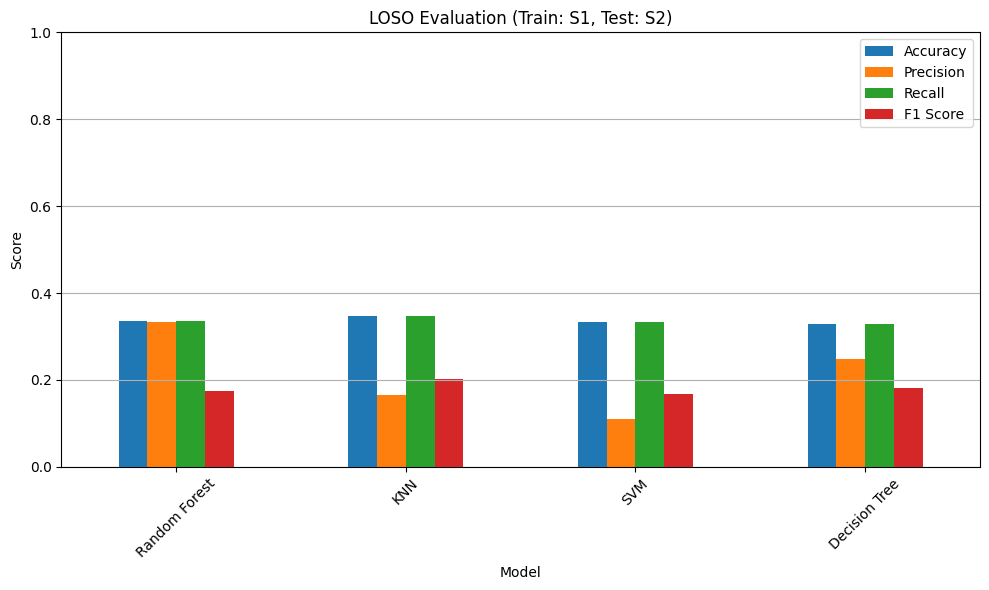

In [ ]:
results_df.plot(kind='bar', figsize=(10, 6), ylim=(0, 1), title="LOSO Evaluation (Train: S1, Test: S2)")
plt.ylabel("Score")
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 10-fold cross-validation

**10-fold Training Evaluation**

*   Train/Test on S1




In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Use only top 20 features
X_final = X_reduced

# 10-fold cross-validation setup
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Evaluate models
results = []

for model_name, model in models.items():
    acc_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for train_idx, test_idx in skf.split(X_final, y): #splitting into train and test
        X_train, X_test = X_final.iloc[train_idx], X_final.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred, average='weighted'))
        recall_scores.append(recall_score(y_test, y_pred, average='weighted'))
        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

    results.append({
        'Model': model_name,
        'Accuracy': np.mean(acc_scores),
        'Precision': np.mean(precision_scores),
        'Recall': np.mean(recall_scores),
        'F1 Score': np.mean(f1_scores)
    })

In [ ]:
# Results DataFrame
results_df = pd.DataFrame(results)
print("\n10-Fold Cross-Validation Results (Top 20 Features):")
print(results_df)


10-Fold Cross-Validation Results (Top 20 Features):
           Model  Accuracy  Precision    Recall  F1 Score
0  Random Forest  0.951347   0.955824  0.951347  0.951659
1            KNN  0.937306   0.941125  0.937306  0.937532
2            SVM  0.949388   0.955814  0.949388  0.949760
3  Decision Tree  0.931061   0.933436  0.931061  0.930723


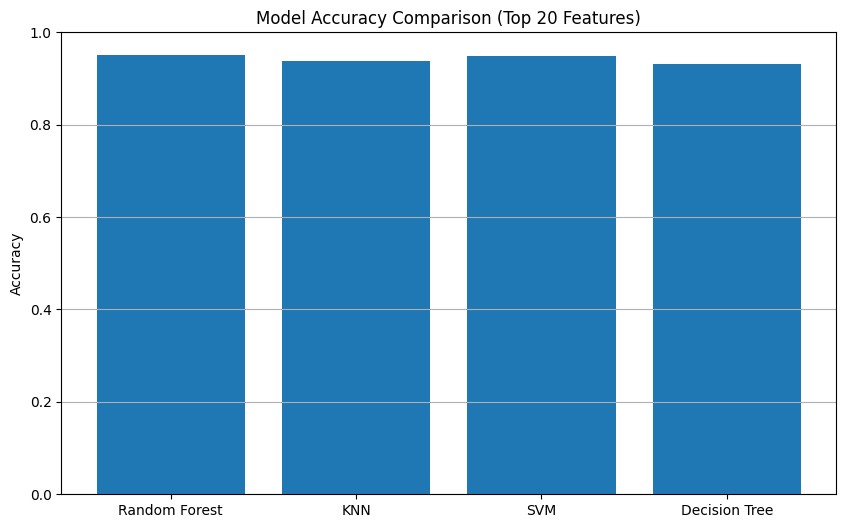

In [ ]:
# ----------------- Visualization 1: Bar Plot of Accuracy -----------------
plt.figure(figsize=(10,6))
plt.bar(results_df['Model'], results_df['Accuracy'])
plt.title('Model Accuracy Comparison (Top 20 Features)')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

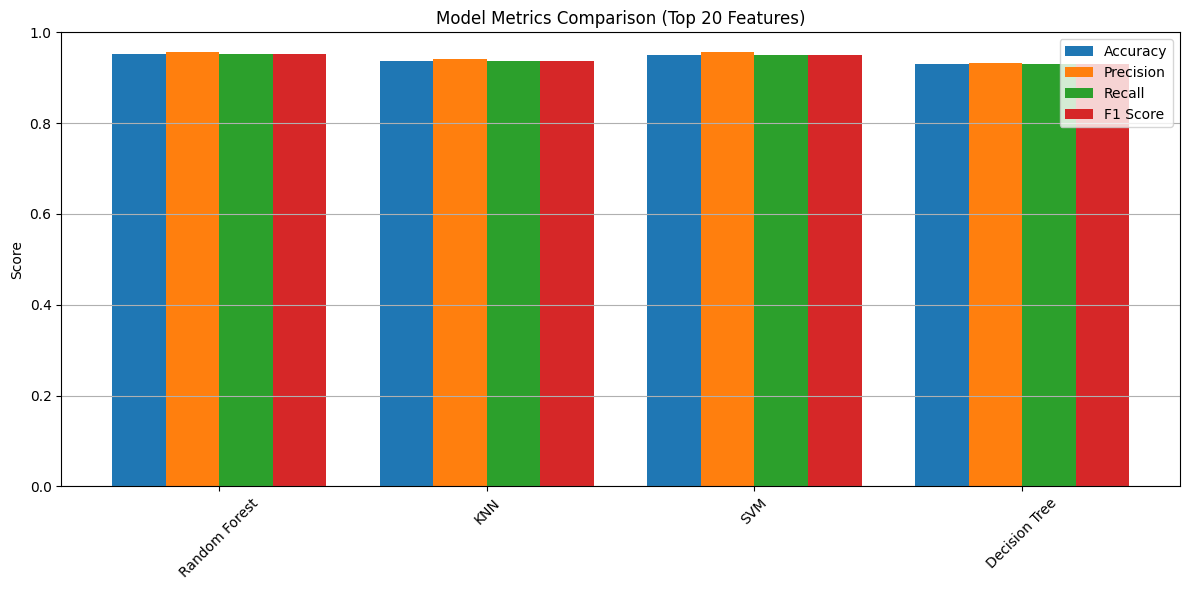

In [ ]:
# Setup
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
x = np.arange(len(results_df['Model']))  # positions for each model
width = 0.2  # width of each bar

plt.figure(figsize=(12,6))

# Plot each metric as a set of bars
for i, metric in enumerate(metrics):
    plt.bar(x + i*width, results_df[metric], width=width, label=metric)

# Labels and Title
plt.title('Model Metrics Comparison (Top 20 Features)')
plt.ylabel('Score')
plt.xticks(x + width*1.5, results_df['Model'], rotation=45)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# **Results Summary**
# In Leave-One-Subject-Out (LOSO) evaluation (Train on Subject 1, Test on Subject 2):


* Random Forest achieved the best performance.

* KNN and Decision Tree also performed well, but slightly lower than Random Forest.

* SVM had the lowest scores among the four models.



# In 10-Fold Cross-Validation (on Subject 1 only):

* All models showed high accuracy (above 92%).

* Random Forest again had the highest scores, followed closely by SVM and KNN.

* Reduced feature set (top 20 features) gave strong performance, indicating that important features were captured effectively.


Overall, Random Forest consistently gave the best results in both LOSO and 10-fold evaluation.
